# Importação de bibliotecas e dataset

In [1]:
# Importações
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import confusion_matrix
from itertools import combinations
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import dask.dataframe as dd
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import datetime


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")

In [2]:
# Leitura do arquivo CSV em partes (chunks) para otimização de uso de memória
csv_file_path = "DrDoS_UDP.csv"
dados = []

In [3]:
# Carregue seus dados (substitua 'seus_dados.csv' pelo nome do seu arquivo)
dados = pd.read_csv(csv_file_path, low_memory=False)

In [4]:
dados = pd.DataFrame(dados)
print(len(dados))
chunk_size = len(dados)
amostra = dados.sample(n=chunk_size)

3136802


# Visualizando parte dos dados e suas colunas

In [5]:
dados.columns = dados.columns.str.strip()
display(dados.describe())
print(dados.columns)

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,...,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06,3.136802e+06
mean,6.284729e+04,4.678466e+04,3.326777e+04,1.699073e+01,9.454659e+04,3.769507e+00,5.931838e-03,1.370530e+03,1.257003e+00,3.885615e+02,...,-3.979974e+07,1.441213e+02,5.098763e+01,1.891834e+02,1.061237e+02,2.348633e+03,1.030996e+02,2.454045e+03,2.266851e+03,9.988192e-01
std,3.640744e+04,8.463285e+03,1.865171e+04,3.255629e-01,6.825386e+05,3.745687e+00,6.018696e-01,1.120631e+03,2.431255e+02,4.950828e+01,...,2.017720e+08,5.206479e+04,3.149175e+04,6.879844e+04,4.339355e+04,3.168890e+05,3.667490e+04,3.264913e+05,3.117682e+05,3.434278e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.062719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.136800e+04,3.980600e+04,1.715900e+04,1.700000e+01,1.000000e+00,2.000000e+00,0.000000e+00,7.660000e+02,0.000000e+00,3.750000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,6.273600e+04,4.689400e+04,3.329400e+04,1.700000e+01,1.320000e+02,4.000000e+00,0.000000e+00,1.398000e+03,0.000000e+00,3.890000e+02,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,9.410400e+04,5.389600e+04,4.942600e+04,1.700000e+01,1.088440e+05,4.000000e+00,0.000000e+00,1.438000e+03,0.000000e+00,3.930000e+02,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.325940e+05,6.553100e+04,6.553500e+04,1.700000e+01,1.200000e+08,2.232000e+03,3.610000e+02,5.907600e+04,2.057900e+05,3.547000e+03,...,1.472000e+03,6.151289e+07,4.868047e+07,7.286843e+07,6.151289e+07,1.166865e+08,3.551041e+07,1.166865e+08,1.166865e+08,1.000000e+00


Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

# Pre-Processamento dos dados

In [6]:
dados_tr = amostra
dados_tr.reset_index(drop=True, inplace=True)

In [7]:
amostra2 = dados[dados['Label'].str.contains('BENIGN')]

In [8]:
# Concatenar amostra e amostra2
dados_tr = pd.concat([amostra, amostra2])

# Redefinir o índice do DataFrame concatenado
dados_tr.reset_index(drop=True, inplace=True)

In [9]:
# Lista das colunas a serem selecionadas
colunas_selecionadas = ['Fwd Packet Length Std', 'Packet Length Std', 'Fwd IAT Mean', 'min_seg_size_forward',
                        'Fwd IAT Max', 'Destination Port', 'Fwd Packet Length Max', 'Fwd Packet Length Mean',
                        'Fwd Packet Length Min', 'Protocol', 'Timestamp', 'Label']

# Remova espaços em branco dos nomes das colunas
dados_tr.columns = dados_tr.columns.str.strip()

In [11]:
# Verifique se todas as colunas selecionadas estão no DataFrame
if set(colunas_selecionadas).issubset(dados_tr.columns):
    # Selecionar apenas as colunas desejadas
    df_dados = dados_tr[colunas_selecionadas]
    # Remover colunas duplicadas
    df_dados = df_dados.loc[:,~df_dados.columns.duplicated()]
    df_dados.reset_index(drop=True, inplace=True)
    df_dados = df_dados.dropna()
    df_dados = df_dados.drop_duplicates()

    # Mostrar todas as colunas disponíveis no novo DataFrame
    print("Colunas Selecionadas:")
    print(df_dados.columns)
    print("\n")
    print(df_dados[df_dados.columns[0]])
else:
    print(dados_tr.columns)
    print(dados_tr)
    print("Nomes das colunas selecionadas não correspondem às colunas no DataFrame.")

Colunas Selecionadas:
Index(['Fwd Packet Length Std', 'Packet Length Std', 'Fwd IAT Mean',
       'min_seg_size_forward', 'Fwd IAT Max', 'Destination Port',
       'Fwd Packet Length Max', 'Fwd Packet Length Mean',
       'Fwd Packet Length Min', 'Protocol', 'Timestamp', 'Label'],
      dtype='object')


0          34.063666
1           0.000000
2          30.127623
3          36.373067
4          22.516660
             ...    
3136797     0.000000
3136798     0.000000
3136799     0.000000
3136800    22.516660
3136801    22.516660
Name: Fwd Packet Length Std, Length: 3136802, dtype: float64


## Tratando o Timestamp e transformando em data da biblioteca pandas.

In [12]:
# Ordenando pelo tempo
df_dados.loc[:,'Timestamp'] = pd.to_datetime(df_dados['Timestamp'])
df_dados = df_dados.sort_values(by='Timestamp')


# Defina os horários de início e fim do intervalo desejado
start_time = pd.to_datetime('12:54:00').time()
end_time = pd.to_datetime('12:55:00').time()

# Filtrar o DataFrame pelo intervalo de tempo
df_dados = df_dados[(df_dados['Timestamp'].dt.time >= start_time) & (df_dados['Timestamp'].dt.time <= end_time)]
display(df_dados)

,Fwd Packet Length Std,Packet Length Std,Fwd IAT Mean,min_seg_size_forward,Fwd IAT Max,Destination Port,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Min,Protocol,Timestamp,Label
2960940,0.00000,0.00000,600136.400000,40.0,2003591.0,22.0,0.0,0.0,0.0,6.0,2018-12-01 12:54:07.177736,DrDoS_UDP
1690953,0.00000,0.00000,5.000000,40.0,5.0,55060.0,1472.0,1472.0,1472.0,17.0,2018-12-01 12:54:09.162039,DrDoS_UDP
989089,0.00000,0.00000,3.000000,40.0,3.0,55060.0,520.0,520.0,520.0,17.0,2018-12-01 12:54:09.162137,DrDoS_UDP
1902138,0.00000,0.00000,3.000000,40.0,3.0,45100.0,1472.0,1472.0,1472.0,17.0,2018-12-01 12:54:09.371612,DrDoS_UDP
3135763,0.00000,0.00000,3.000000,40.0,3.0,45100.0,520.0,520.0,520.0,17.0,2018-12-01 12:54:09.371796,DrDoS_UDP
...,...,...,...,...,...,...,...,...,...,...,...,...
1902292,22.51666,21.36118,35375.333333,0.0,106123.0,26954.0,369.0,349.5,330.0,17.0,2018-12-01 12:54:59.998739,DrDoS_UDP
2934032,0.00000,0.00000,1.000000,0.0,1.0,43224.0,383.0,383.0,383.0,17.0,2018-12-01 12:54:59.998802,DrDoS_UDP
318635,0.00000,0.00000,1.000000,0.0,1.0,36668.0,401.0,401.0,401.0,17.0,2018-12-01 12:54:59.999169,DrDoS_UDP
2296050,0.00000,0.00000,1.000000,0.0,1.0,16185.0,401.0,401.0,401.0,17.0,2018-12-01 12:54:59.999171,DrDoS_UDP


Vendo as classificações dos meus dados

In [13]:
display(dados['Label'].unique())

array(['DrDoS_UDP', 'BENIGN'], dtype=object)

# Criando relação para o Histograma

In [14]:
# Função para criar gráfico de série temporal de uma coluna
def sns_x(coluna, maior, menor):
    output = f"img_com_intervalo/histplot_Density_{coluna.replace(' ', '_')}.png"
    plot = sns.histplot(data=df_dados, x=coluna, hue="Label", kde=True, stat="density", kde_kws=dict(cut=3), bins=100)
    fig = plot.get_figure()
    
    # Salvar o gráfico
    fig.savefig(output)
    

def criar_sns_densidade(coluna, maior, menor):
    sns_x(coluna, maior, menor)
    
print(len(colunas_selecionadas))

    

12


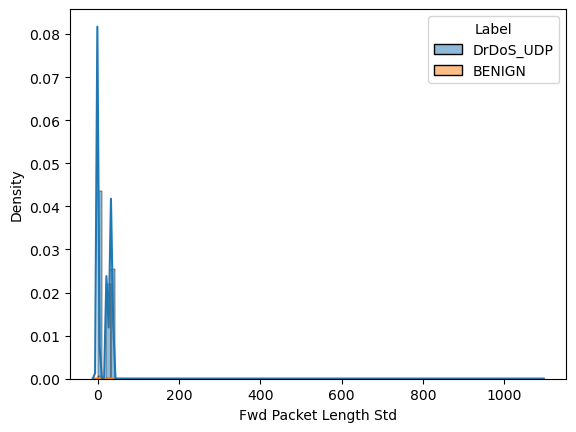

In [15]:
criar_sns_densidade(colunas_selecionadas[0], maior=0, menor=100)

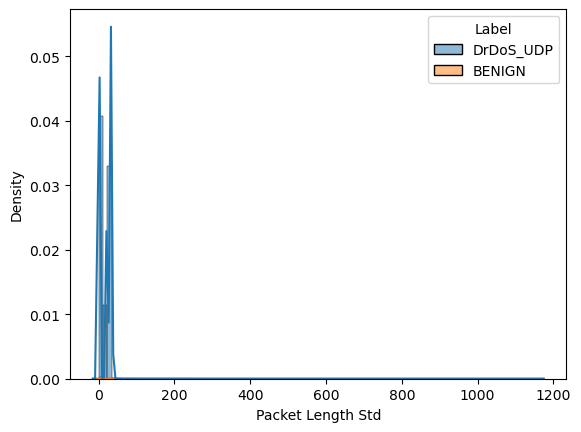

In [16]:
criar_sns_densidade(colunas_selecionadas[1], maior=0, menor=50)


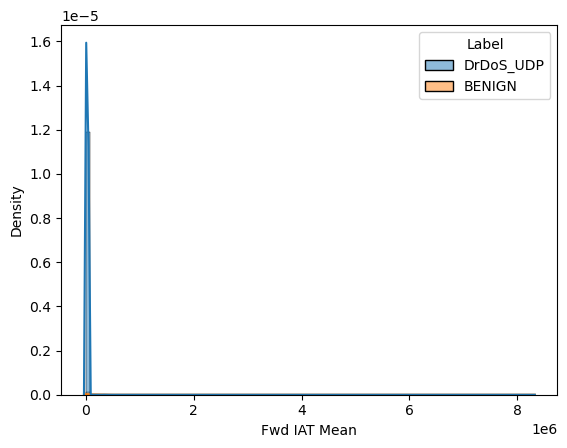

In [17]:
criar_sns_densidade(colunas_selecionadas[2], maior=0, menor=70000)


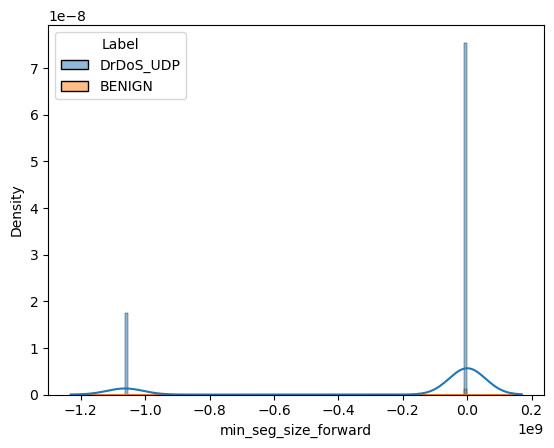

In [18]:
criar_sns_densidade(colunas_selecionadas[3], maior=0, menor=500)


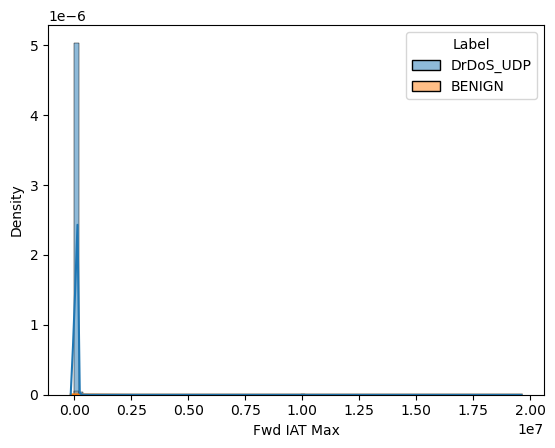

In [19]:
criar_sns_densidade(colunas_selecionadas[4], maior=0, menor=150000)


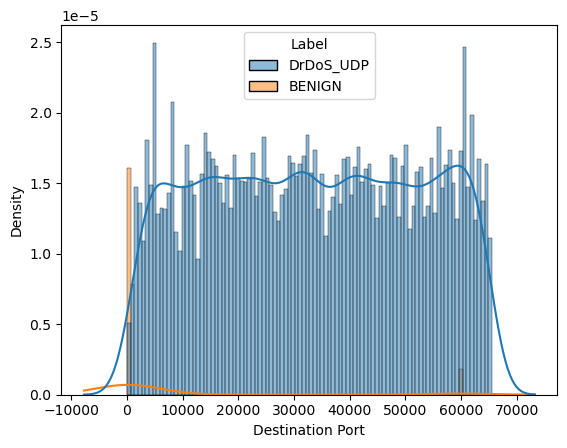

In [20]:
criar_sns_densidade(colunas_selecionadas[5], maior=0, menor=80000)


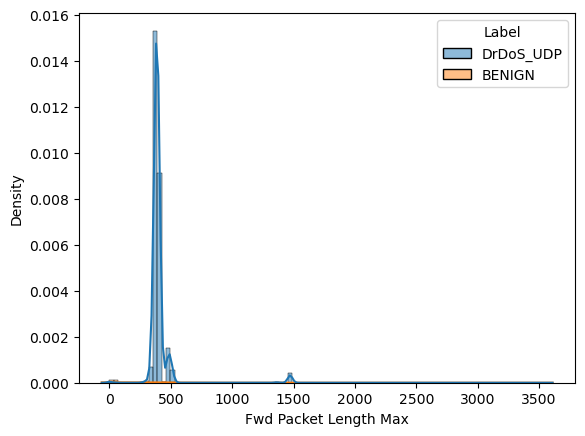

In [21]:
criar_sns_densidade(colunas_selecionadas[6], maior=200, menor=550)


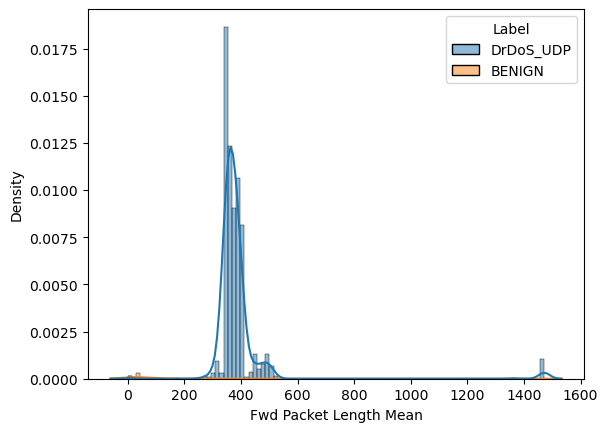

In [22]:
criar_sns_densidade(colunas_selecionadas[7], maior=250, menor=500)


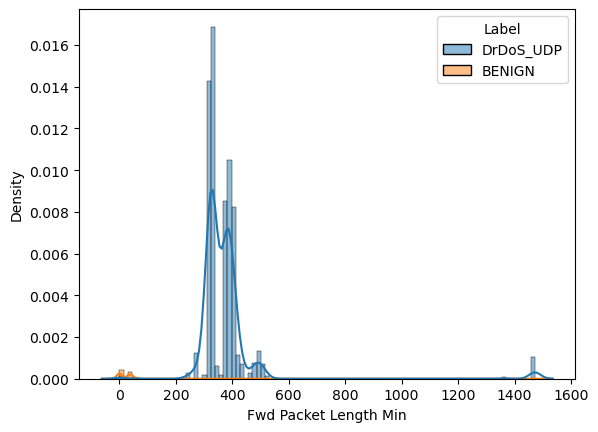

In [23]:
criar_sns_densidade(colunas_selecionadas[8], maior=250, menor=500)


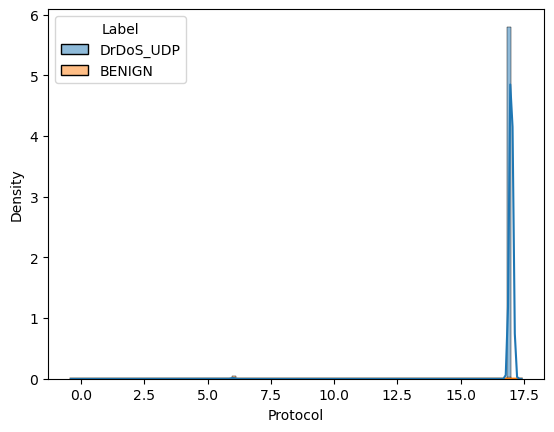

In [24]:
criar_sns_densidade(colunas_selecionadas[9], maior=15, menor=19)

# Criando histograma, porem considerando o timestamp

In [73]:
import matplotlib.ticker as ticker

# Função para criar gráfico de série temporal de uma coluna
def criar_sns_histograma(coluna, timestamp, intervalo_ticks=10):
    output = f"img_com_intervalo/histplot_timestamp_{coluna.replace(' ', '_')}.png"
    # Ajustar o tamanho da figura para alongar verticalmente
    plt.figure(figsize=(7, 11))  # Largura=10, Altura=20 (ajuste conforme necessário)
    plot = sns.histplot(data=df_dados, y=coluna, x=timestamp, kde_kws=dict(cut=3), hue="Label")

    # Obter os valores únicos no eixo y
    unique_y_values = sorted(df_dados[coluna].unique())
    
    # Selecionar ticks em intervalos regulares
    selected_ticks = unique_y_values[::intervalo_ticks]  # Exibir a cada `intervalo_ticks` valores
    plot.set_yticks(selected_ticks)  # Definir os ticks no eixo y
    plot.set_yticklabels(selected_ticks, rotation=0)  # Rótulos legíveis (ajuste o rotation se necessário)

    fig = plot.get_figure()
    fig.savefig(output)

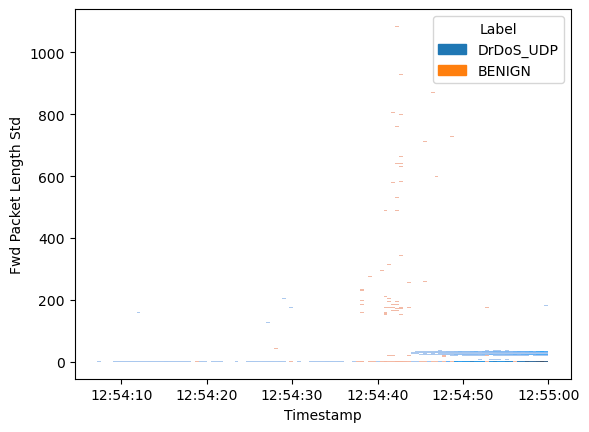

In [26]:
criar_sns_histograma(coluna=colunas_selecionadas[0], timestamp=colunas_selecionadas[10])


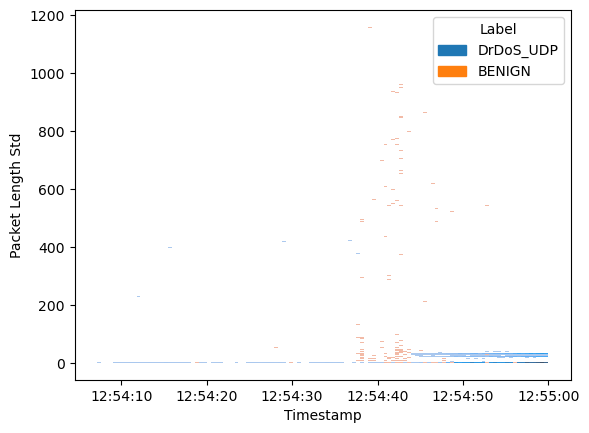

In [27]:
criar_sns_histograma(coluna=colunas_selecionadas[1], timestamp=colunas_selecionadas[10])


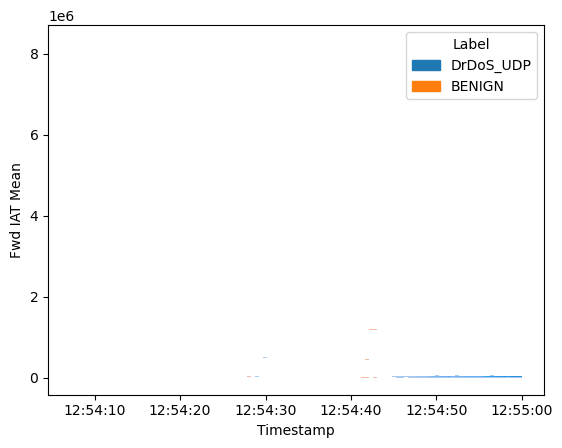

In [28]:
criar_sns_histograma(coluna=colunas_selecionadas[2], timestamp=colunas_selecionadas[10])


MemoryError: Unable to allocate 5.50 GiB for an array with shape (738487390,) and data type float64

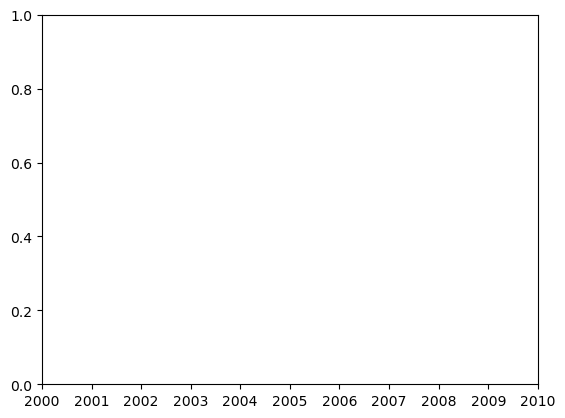

In [31]:
criar_sns_histograma(coluna=colunas_selecionadas[3], timestamp=colunas_selecionadas[10])


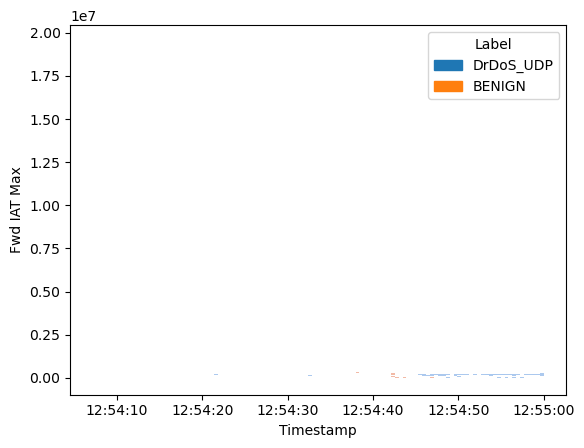

In [32]:
criar_sns_histograma(coluna=colunas_selecionadas[4], timestamp=colunas_selecionadas[10])


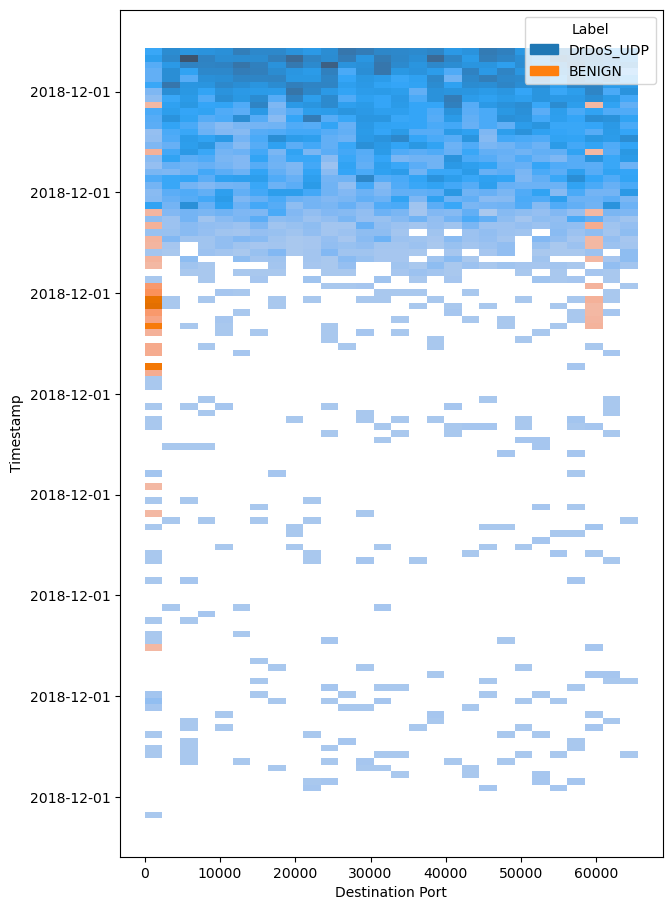

In [72]:
criar_sns_histograma(coluna=colunas_selecionadas[10], timestamp=colunas_selecionadas[5])


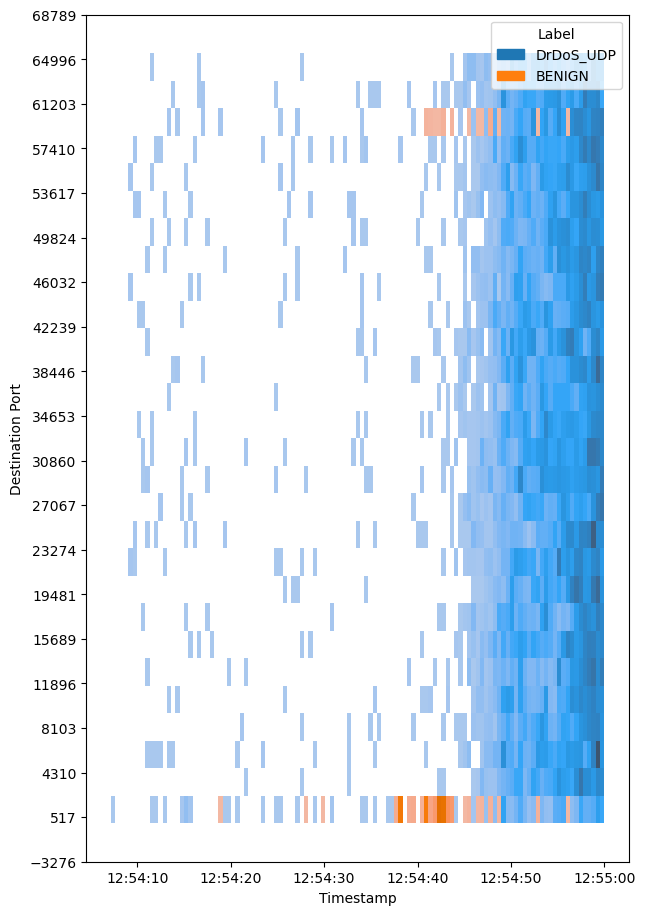

In [56]:
criar_sns_histograma(coluna=colunas_selecionadas[5], timestamp=colunas_selecionadas[10])


In [ ]:
criar_sns_histograma(coluna=colunas_selecionadas[6], timestamp=colunas_selecionadas[10])


In [ ]:
criar_sns_histograma(coluna=colunas_selecionadas[7], timestamp=colunas_selecionadas[10])


In [ ]:
criar_sns_histograma(coluna=colunas_selecionadas[8], timestamp=colunas_selecionadas[10])


In [ ]:
criar_sns_histograma(coluna=colunas_selecionadas[9], timestamp=colunas_selecionadas[10])

# Criando o boxplot de cada coluna

In [ ]:
# Função para criar gráfico de série temporal de uma coluna
def criar_sns_boxplot_timestamp(coluna, maior, menor):
    output = f"img_com_intervalo/boxplot_{coluna.replace(' ', '_')}.png"
    plot = sns.boxplot(data=df_dados, x=coluna, y="Label")
    fig = plot.get_figure()
    fig.savefig(output)

In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[0], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[1], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[2], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[3], maior=-1.1, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[4], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[5], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[6], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[7], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[8], maior=-1.0, menor=80000.0)


In [ ]:
criar_sns_boxplot_timestamp(colunas_selecionadas[9], maior=-1.0, menor=80000.0)

# Criando o boxplot de cada coluna mas comparando elas

In [ ]:
def plot_boxplot(ps1, ps2):
    # Crie os DataFrames a partir das colunas fornecidas
    dfs = []
    
    # Crie os DataFrames a partir das colunas fornecidas
    for coluna in colunas_selecionadas[ps1:ps2]:
        df = pd.DataFrame({'group': coluna, 'value': df_dados[coluna]})
        dfs.append(df)
    
    # Concatene os DataFrames usando a função concat
    df_teste = pd.concat(dfs)
    
    output = f"img_com_intervalo/boxplot_comparaty_{colunas_selecionadas[ps1].replace(' ', '_')}_E_{colunas_selecionadas[ps2].replace(' ', '_')}.png"
    
    # Usual boxplot
    plot = sns.boxplot(data=df_teste, x='group', y='value')
    fig = plot.get_figure()
    fig.savefig(output)

In [ ]:
plot_boxplot(0,1)


In [ ]:
plot_boxplot(1,2)


In [ ]:
plot_boxplot(2,3)


In [ ]:
plot_boxplot(3,4)


In [ ]:
plot_boxplot(4,5)


In [ ]:
plot_boxplot(5,6)


In [ ]:
plot_boxplot(6,7)


In [ ]:
plot_boxplot(7,8)


In [ ]:
plot_boxplot(8,9)


In [ ]:
plot_boxplot(9,10)

# Criando o violinplot de cada coluna em comparação

In [ ]:
def plot_violinplot(ps1, ps2, df_dados, colunas_selecionadas):
    # Crie os DataFrames a partir das colunas fornecidas
    dfs = []
    
    # Crie os DataFrames a partir das colunas fornecidas
    for coluna in colunas_selecionadas[ps1:ps2]:
        df = pd.DataFrame({'group': coluna + f'_{ps1}_{ps2}', 'value': df_dados[coluna]})
        dfs.append(df)
    
    # Concatene os DataFrames usando a função concat
    df_teste = pd.concat(dfs)
    
    output = f"img_com_intervalo/violinplot_comparaty_{colunas_selecionadas[ps1].replace(' ', '_')}_E_{colunas_selecionadas[ps2].replace(' ', '_')}.png"
    
    # Usual boxplot
    plot = sns.violinplot(x='group', y='value', data=df_teste)
    fig = plot.get_figure()
    fig.savefig(output)

In [ ]:
plot_violinplot(0,2, df_dados, colunas_selecionadas)


In [ ]:
plot_violinplot(2,4, df_dados, colunas_selecionadas)


In [ ]:
plot_violinplot(4,6, df_dados, colunas_selecionadas)


In [ ]:
plot_violinplot(6,8, df_dados, colunas_selecionadas)


In [ ]:
plot_violinplot(8,10, df_dados, colunas_selecionadas)

# Criando o violinplot de cada coluna de forma unica

In [ ]:
def plot_violinplo2(coluna):
    output = f"img_com_intervalo/violinplot_{coluna.replace(' ', '_')}.png"
    plot = sns.violinplot(data=df_dados, x='Label', y=coluna)
    fig = plot.get_figure()
    fig.savefig(output)

In [ ]:
plot_violinplo2(colunas_selecionadas[0])


In [ ]:
plot_violinplo2(colunas_selecionadas[1])


In [ ]:
plot_violinplo2(colunas_selecionadas[2])


In [ ]:
plot_violinplo2(colunas_selecionadas[3])


In [ ]:
plot_violinplo2(colunas_selecionadas[4])


In [ ]:
plot_violinplo2(colunas_selecionadas[5])


In [ ]:
plot_violinplo2(colunas_selecionadas[6])


In [ ]:
plot_violinplo2(colunas_selecionadas[7])


In [ ]:
plot_violinplo2(colunas_selecionadas[8])


In [ ]:
plot_violinplo2(colunas_selecionadas[9])


# Analisando a relação de distribuição de cada coluna

In [ ]:
def criar_sns_marginal_distribution(df, coluna, coluna2):
    output = f"img_com_intervalo/jointplot_{coluna.replace(' ', '_')}.png"
    plot = sns.jointplot(data=df, x=coluna, y=coluna2, kind="hist", hue="Label")
    fig = plot.fig
    fig.savefig(output)

In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[0], 
                                coluna2=colunas_selecionadas[1])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[1], 
                                coluna2=colunas_selecionadas[2])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[2], 
                                coluna2=colunas_selecionadas[3])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[3], 
                                coluna2=colunas_selecionadas[4])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[4], 
                                coluna2=colunas_selecionadas[5])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[5], 
                                coluna2=colunas_selecionadas[6])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[6], 
                                coluna2=colunas_selecionadas[7])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[7], 
                                coluna2=colunas_selecionadas[8])


In [ ]:
criar_sns_marginal_distribution(df_dados,
                                coluna=colunas_selecionadas[8], 
                                coluna2=colunas_selecionadas[9])


# Criando o Pairplot para verificar a distribuição a todas colunas

Informação importante sobre o Pairplot. Como eu tenho pelo menos 10 colunas principais, eu dividir elas em guadrantes e e fiz as comparações. É a famosa divisão para comquistar. Dessa forma é mais rapido e gera o mesmo resultado. 

In [ ]:
def criar_sns_pairplot(df, num):
    output = f"img_com_intervalo/pairplot_{num}.png"
    plot = sns.pairplot(df, hue="Label")
    fig = plot.fig
    fig.savefig(output)

In [ ]:
# Lista das colunas a serem selecionadas 1
colunas_selecionadas1 = ['Fwd Packet Length Std', 'Packet Length Std', 'Fwd IAT Mean','min_seg_size_forward', 
                         'Fwd IAT Max','Timestamp','Label']

# Lista das colunas a serem selecionadas 2
colunas_selecionadas2 = ['Fwd Packet Length Std', 'Packet Length Std', 'Fwd IAT Mean','Destination Port',
                         'Fwd Packet Length Max', 'Fwd Packet Length Mean','Timestamp', 'Label']

# Lista das colunas a serem selecionadas 3
colunas_selecionadas3 = ['Fwd Packet Length Std', 'Packet Length Std', 'Fwd IAT Mean','Fwd Packet Length Min',
                         'Protocol','Timestamp', 'Label' ]

# Lista das colunas a serem selecionadas 4
colunas_selecionadas4 = ['min_seg_size_forward', 'Fwd IAT Max','Destination Port','Fwd Packet Length Max', 
                         'Fwd Packet Length Mean','Timestamp', 'Label']

# Lista das colunas a serem selecionadas 5
colunas_selecionadas5 = ['min_seg_size_forward','Fwd IAT Max', 'Fwd Packet Length Min','Protocol','Timestamp', 
                         'Label' ]

# Lista das colunas a serem selecionadas 6
colunas_selecionadas6 = ['Fwd Packet Length Min','Protocol','Destination Port','Fwd Packet Length Max', 
                         'Fwd Packet Length Mean','Timestamp', 'Label']

# Lista das colunas a serem selecionadas 6
colunas_selecionadas7 = ['Fwd Packet Length Mean', 'Fwd IAT Mean', 'min_seg_size_forward', 'Destination Port', 
                         'Protocol', 'Timestamp', 'Label']

# Selecionar apenas as colunas desejadas
df_dados1 = df_dados[colunas_selecionadas1]
df_dados2 = df_dados[colunas_selecionadas2]
df_dados3 = df_dados[colunas_selecionadas3]
df_dados4 = df_dados[colunas_selecionadas4]
df_dados5 = df_dados[colunas_selecionadas5]
df_dados6 = df_dados[colunas_selecionadas6]
df_dados7 = df_dados[colunas_selecionadas7]

In [ ]:
criar_sns_pairplot(df_dados1, 1)

In [ ]:
criar_sns_pairplot(df_dados2, 2)

In [ ]:
criar_sns_pairplot(df_dados3, 3)

In [ ]:
criar_sns_pairplot(df_dados4, 4)

In [ ]:
criar_sns_pairplot(df_dados5, 5)

In [ ]:
criar_sns_pairplot(df_dados6, 6)

In [ ]:
criar_sns_pairplot(df_dados7, 7)

# Correlação por meio do headmap.

In [ ]:
def criar_sns_hearmapcor(df, num):
    output = f"img/hearmapcor_{num}.png"
    plot = sns.heatmap(df.corr())

In [ ]:
criar_sns_hearmapcor(df_dados1, 1)

In [ ]:
criar_sns_hearmapcor(df_dados2, 2)

In [ ]:
criar_sns_hearmapcor(df_dados3, 3)

In [ ]:
criar_sns_hearmapcor(df_dados5, 4)

In [ ]:
criar_sns_hearmapcor(df_dados5, 5)

In [ ]:
criar_sns_hearmapcor(df_dados6, 6)

In [ ]:
criar_sns_hearmapcor(df_dados7, 7)

# Pandas Profiling Report

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
profile1 = ProfileReport(df_dados7, title="Pandas Profiling Report")

In [ ]:
profile1.to_file("img/report_1.html")